In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Reviews.csv")

In [3]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [4]:
df = df.dropna(subset=['UserId', 'ProductId', 'Score', 'Text'])
df = df.drop_duplicates()
df = df[df['Score'].between(1, 5)]

In [5]:
shape = df.shape
unique_users = df['UserId'].nunique()
unique_products = df['ProductId'].nunique()
print(f" Dataset Shape: {shape}")
print(f" Total Unique Users: {unique_users}")
print(f" Total Unique Products: {unique_products}")

 Dataset Shape: (568454, 10)
 Total Unique Users: 256059
 Total Unique Products: 74258


 <span style="font-size:20px; color:blue">SENTIMENT ANALYSIS USING VADER</span>

In [7]:
analyzer = SentimentIntensityAnalyzer()

In [8]:
def get_vader_scores(text):
    scores = analyzer.polarity_scores(str(text))
    return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']])

df[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']] = df['Text'].apply(get_vader_scores)

def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['vader_compound'].apply(classify_sentiment)

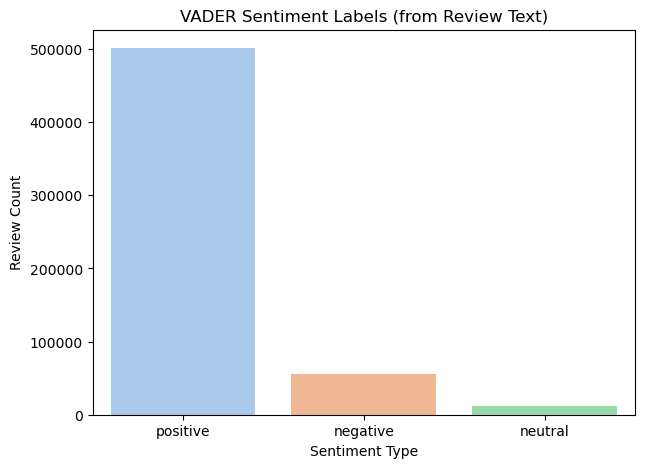

In [9]:
plt.figure(figsize=(7,5))
sns.countplot(x='vader_sentiment', data=df, palette='pastel')
plt.title("VADER Sentiment Labels (from Review Text)")
plt.xlabel("Sentiment Type")
plt.ylabel("Review Count")
plt.show()


<span style="font-size:20px; color:blue">HELPFULNESS RATIO AND REVIEW WEIGHT</span> 

In [11]:
df['helpfulness_ratio'] = df.apply(
    lambda row: row['HelpfulnessNumerator'] / row['HelpfulnessDenominator']
    if row['HelpfulnessDenominator'] != 0 else 0, axis=1)

In [12]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,vader_neg,vader_neu,vader_pos,vader_compound,vader_sentiment,helpfulness_ratio
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.000,0.711,0.289,0.9441,positive,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.138,0.862,0.000,-0.5664,negative,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0.085,0.771,0.144,0.8138,positive,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.000,0.932,0.068,0.4404,positive,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.000,0.599,0.401,0.9468,positive,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,0.068,0.623,0.309,0.8589,positive,0.0
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,0.241,0.717,0.042,-0.8780,negative,0.0
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",0.037,0.886,0.077,0.4352,positive,1.0
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,0.041,0.506,0.452,0.9717,positive,1.0


In [13]:
def compute_weight(row):
    weight = 1.0
    if row['vader_sentiment'] == 'positive':
        weight += 0.5
    weight += row['helpfulness_ratio']
    return weight

df['weighted_score'] = df['Score'] * df.apply(compute_weight, axis=1)

In [14]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,vader_neg,vader_neu,vader_pos,vader_compound,vader_sentiment,helpfulness_ratio,weighted_score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.000,0.711,0.289,0.9441,positive,1.0,12.5
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.138,0.862,0.000,-0.5664,negative,0.0,1.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0.085,0.771,0.144,0.8138,positive,1.0,10.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.000,0.932,0.068,0.4404,positive,1.0,5.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.000,0.599,0.401,0.9468,positive,0.0,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,0.068,0.623,0.309,0.8589,positive,0.0,7.5
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,0.241,0.717,0.042,-0.8780,negative,0.0,2.0
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",0.037,0.886,0.077,0.4352,positive,1.0,12.5
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,0.041,0.506,0.452,0.9717,positive,1.0,12.5


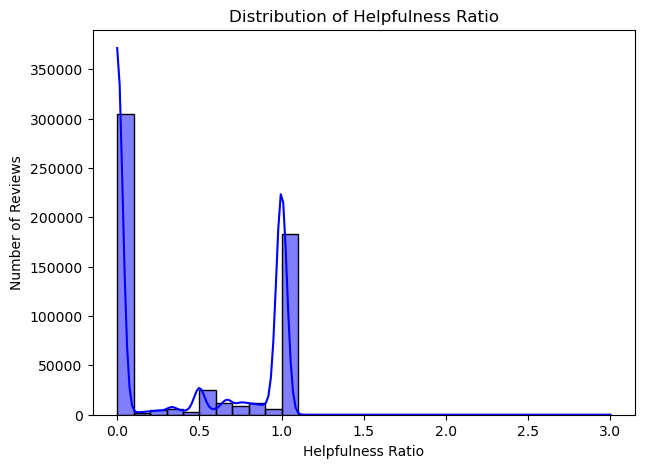

In [15]:
plt.figure(figsize=(7,5))
sns.histplot(df['helpfulness_ratio'], bins=30, kde=True, color='blue')
plt.title("Distribution of Helpfulness Ratio")
plt.xlabel("Helpfulness Ratio")
plt.ylabel("Number of Reviews")
plt.show()


<span style="font-size:20px; color:blue">FILTERING ACTUAL USERS AND PRODUCTS AND VISUALIZATION OF TOP PRODUCTS</span>

In [17]:
top_users = df['UserId'].value_counts().head(1000).index
top_products = df['ProductId'].value_counts().head(1000).index

filtered_df = df[df['UserId'].isin(top_users) & df['ProductId'].isin(top_products)]
print(f" Filtered Dataset Shape: {filtered_df.shape}")
print(f" Unique Users After Filter: {filtered_df['UserId'].nunique()}")
print(f" Unique Products After Filter: {filtered_df['ProductId'].nunique()}")

 Filtered Dataset Shape: (20591, 17)
 Unique Users After Filter: 927
 Unique Products After Filter: 971


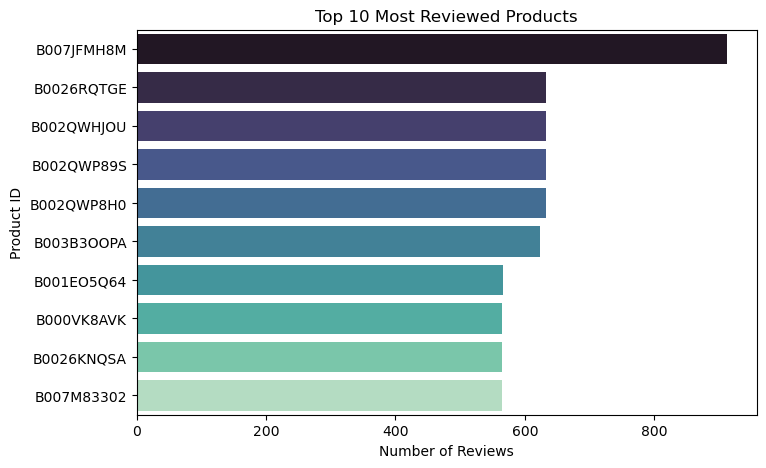

In [18]:
top_products = df['ProductId'].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=top_products.values, y=top_products.index, palette='mako')
plt.title("Top 10 Most Reviewed Products")
plt.xlabel("Number of Reviews")
plt.ylabel("Product ID")
plt.show()


<span style="font-size:20px; color:blue">USER PRODUCT MATRIX AND USER SIMILARITY</span>

In [20]:
user_product_matrix = filtered_df.pivot_table(index='UserId', columns='ProductId', values='weighted_score')
user_product_matrix_filled = user_product_matrix.fillna(0)


In [21]:
user_sparse_matrix = csr_matrix(user_product_matrix_filled.values)
user_sim_matrix = cosine_similarity(user_sparse_matrix)

user_sim_df = pd.DataFrame(user_sim_matrix,
                           index=user_product_matrix_filled.index,
                           columns=user_product_matrix_filled.index)


In [22]:
print(f" User Similarity Matrix Shape: {user_sim_df.shape}")
print(" Preview of top-left 5x5 section:")
print(user_sim_df.iloc[:5, :5])

 User Similarity Matrix Shape: (927, 927)
 Preview of top-left 5x5 section:
UserId          A100WO06OQR8BQ  A106ZCP7RSXMRU  A1080SE9X3ECK0  \
UserId                                                           
A100WO06OQR8BQ         1.00000             0.0             0.0   
A106ZCP7RSXMRU         0.00000             1.0             0.0   
A1080SE9X3ECK0         0.00000             0.0             1.0   
A10AFVU66A79Y1         0.17227             0.0             0.0   
A10G136JEISLVR         0.00000             0.0             0.0   

UserId          A10AFVU66A79Y1  A10G136JEISLVR  
UserId                                          
A100WO06OQR8BQ         0.17227             0.0  
A106ZCP7RSXMRU         0.00000             0.0  
A1080SE9X3ECK0         0.00000             0.0  
A10AFVU66A79Y1         1.00000             0.0  
A10G136JEISLVR         0.00000             1.0  


<span style="font-size:20px; color:blue">COLLABORATIVE FILTERING MODEL USER BASED</span>

In [24]:
def find_similar_users(target_user_id, top_n=5):
    if target_user_id not in user_sim_df.index:
        return []
    sim_scores = user_sim_df.loc[target_user_id].sort_values(ascending=False)
    return sim_scores.iloc[1:top_n+1].index.tolist()

def generate_recommendations(user_id, top_n=5):
    if user_id not in user_product_matrix_filled.index:
        return pd.DataFrame()
    similar_users = find_similar_users(user_id, top_n=5)
    user_rated = user_product_matrix_filled.loc[user_id]
    unseen_products = user_rated[user_rated == 0].index
    weighted_scores = pd.Series(0, index=unseen_products, dtype=np.float64)
    for sim_user in similar_users:
        sim_score = user_sim_df.loc[user_id, sim_user]
        sim_user_ratings = user_product_matrix_filled.loc[sim_user, unseen_products]
        weighted_scores += sim_score * sim_user_ratings
    recommended_products = weighted_scores.sort_values(ascending=False).head(top_n)
    return recommended_products.reset_index(name='PredictedScore')


In [25]:
sample_user = user_product_matrix_filled.index[0]
print("Top recommendations for user:", sample_user)
print(generate_recommendations(sample_user, top_n=5))


Top recommendations for user: A100WO06OQR8BQ
    ProductId  PredictedScore
0  B002TMV3CG        8.304255
1  B004FEN3GK        7.922472
2  B007I7Z3Z0        6.168584
3  B007I7YZJK        6.168584
4  B004MO6NI8        5.062972


<span style="font-size:20px; color:blue">POPULARITY BASED RECOMMENDER SYSTEM</span>

In [27]:
popularity_df = df.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
popularity_df.columns = ['ProductId', 'TotalReviews']
popularity_df = popularity_df.sort_values(by=['TotalReviews', 'ProductId'], ascending=[False, True])
popularity_df['Rank'] = popularity_df['TotalReviews'].rank(method='first', ascending=False)

top_popular = popularity_df.head(5)

def get_top_products(user_id):
    recs = top_popular.copy()
    recs['UserId'] = user_id
    cols = ['UserId'] + [col for col in recs.columns if col != 'UserId']
    return recs[cols]

user_list = [15, 121, 200]
for user in user_list:
    print(f"Popular products for User {user}")
    print(get_top_products(user))
    print("-" * 40)


Popular products for User 15
       UserId   ProductId  TotalReviews  Rank
71170      15  B007JFMH8M           913   1.0
37898      15  B0026RQTGE           632   2.0
42257      15  B002QWHJOU           632   3.0
42263      15  B002QWP89S           632   4.0
42264      15  B002QWP8H0           632   5.0
----------------------------------------
Popular products for User 121
       UserId   ProductId  TotalReviews  Rank
71170     121  B007JFMH8M           913   1.0
37898     121  B0026RQTGE           632   2.0
42257     121  B002QWHJOU           632   3.0
42263     121  B002QWP89S           632   4.0
42264     121  B002QWP8H0           632   5.0
----------------------------------------
Popular products for User 200
       UserId   ProductId  TotalReviews  Rank
71170     200  B007JFMH8M           913   1.0
37898     200  B0026RQTGE           632   2.0
42257     200  B002QWHJOU           632   3.0
42263     200  B002QWP89S           632   4.0
42264     200  B002QWP8H0           632   5.0
-

<span style="font-size:20px; color:blue">USER PRODUCT INTERACTION NETWORK AND SENTIMENT HEAT MAPS </span>

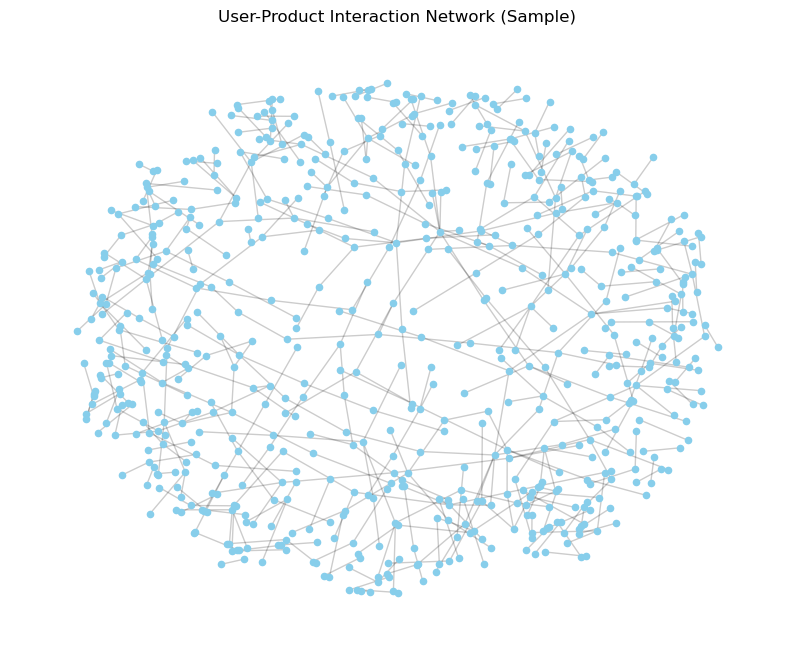

In [29]:
sample_df = filtered_df.sample(500, random_state=42)

G = nx.Graph()
G.add_nodes_from(sample_df['UserId'], bipartite='users')
G.add_nodes_from(sample_df['ProductId'], bipartite='products')

edges = list(zip(sample_df['UserId'], sample_df['ProductId']))
G.add_edges_from(edges)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.15)
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue')
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("User-Product Interaction Network (Sample)")
plt.axis('off')
plt.show()


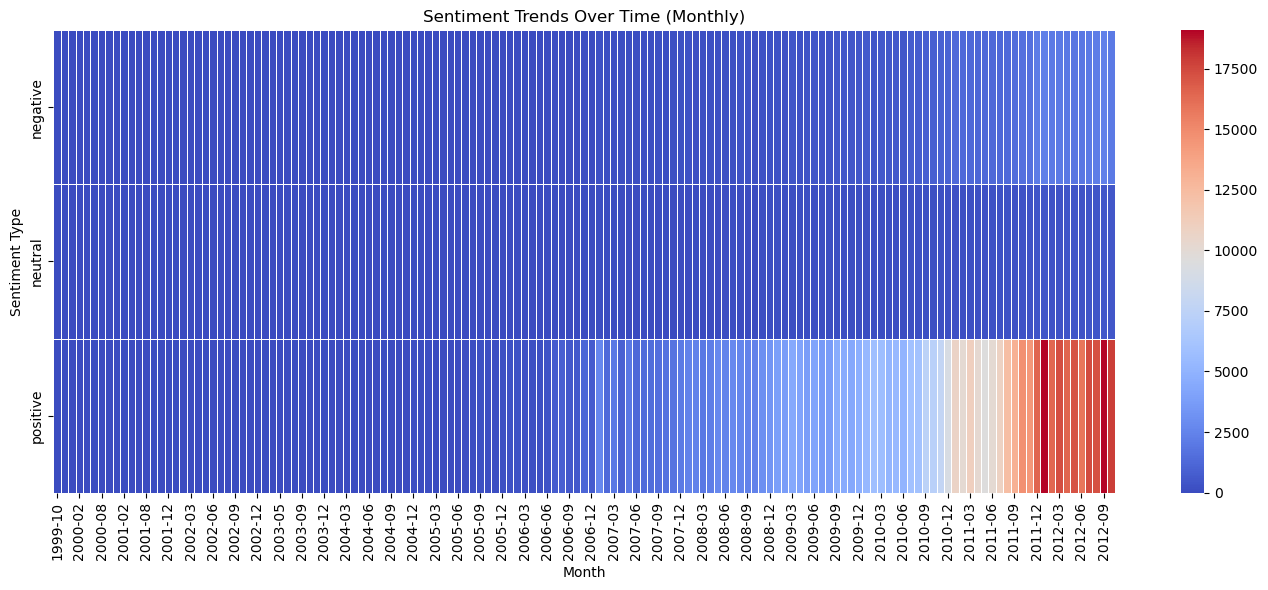

In [30]:
df['ReviewTime'] = pd.to_datetime(df['Time'], unit='s')

sentiment_time = df.groupby([df['ReviewTime'].dt.to_period('M'), 'vader_sentiment']).size().unstack().fillna(0)

plt.figure(figsize=(14, 6))
sns.heatmap(sentiment_time.T, cmap='coolwarm', linewidths=0.5)
plt.title("Sentiment Trends Over Time (Monthly)")
plt.xlabel("Month")
plt.ylabel("Sentiment Type")
plt.tight_layout()
plt.show()
